In [296]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [297]:
def obstacle_penalty(observation, penalty_factor):
    """
    Calculates the value of probability density function of a bivariate normal distribution at a given point.
    Arguments:
    x, y : float
        Coordinates of the point at which to calculate the probability density value.
    mu_x, mu_y : float
        Mean values (expectations) along the X and Y axes, respectively.
    sigma_x, sigma_y : float
        Standard deviations along the X and Y axes, respectively.
    rho : float
        Correlation coefficient between X and Y.

    Returns:
    float
        Value of the probability density function of a bivariate normal distribution at the given point (x, y).
    """
    mu_x = obstacle_x = -0.5
    sigma_x = obstacle_sigma = 0.2

    mu_y = obstacle_y = -0.5
    sigma_y = obstacle_sigma = 0.2
    rho = 0
    x = observation[0]
    y = observation[1]
    z = ((x - mu_x) ** 2) / (sigma_x ** 2) + ((y - mu_y) ** 2) / (sigma_y ** 2) - (2 * rho * (x - mu_x) * (y - mu_y)) / (sigma_x * sigma_y)
    denom = 2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho ** 2)
    return np.exp(-z / (2 * (1 - rho ** 2))) / denom * penalty_factor

In [298]:
x_lim = y_lim = [-1, 0]
X = np.arange(x_lim[0], x_lim[1], 0.01)
Y = np.arange(y_lim[0], y_lim[1], 0.01)

X, Y = np.meshgrid(X, Y)
Z = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z.append(obstacle_penalty(observation=[X[i, j], Y[i, j]], penalty_factor=1e1))

Z = np.array(Z).reshape((X.shape[0], X.shape[1]))
# len(Z)

In [299]:
linestyle_dict = {
     'loosely dotted': (0, (1, 10)),
     'dotted': (0, (1, 1)),
     'densely dotted': (0, (1, 1)),
     'long dash with offset': (5, (10, 3)),
     'loosely dashed': (0, (5, 10)),
     'dashed': (0, (5, 5)),
     'densely dashed': (0, (5, 1)),
     'loosely dashdotted': (0, (3, 10, 1, 10)),
     'dashdotted': (0, (3, 5, 1, 5)),
     'densely dashdotted': (0, (3, 1, 1, 1)),
     'dashdotdotted': (0, (3, 5, 1, 5, 1, 5)),
     'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
     'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1)),
     'solid': 'solid'
}
style = {
            1: "dotted", 
            5: "solid", 
            10: "dashed", 
            50: "dashdotted", 
            100: "loosely dashdotted"
        }

colors = {
            1: "tab:orange", 
            5: "tab:blue", 
            10: "tab:green", 
            50: "tab:red", 
            100: "tab:purple"
        }

In [300]:
# data_dir = "regelum_data/outputs/2024-07-23/12-21-55/0/.callbacks/HistoricalDataCallback"
# data_dir = "regelum_data/outputs/2024-07-24/12-17-15/0/.callbacks/HistoricalDataCallback"
data_dir = "regelum_data/outputs/2024-07-25/13-36-48"
data_dir = "regelum_data/outputs/2024-07-25/15-12-39"

def get_df_from_folder(data_dir):
    df_list = []
    for root, dirs, files in os.walk(data_dir):
        if not root.endswith("HistoricalDataCallback"):
            continue

        for fn in files:
            if not fn.endswith(".h5"):
                continue

            file_path = os.path.join(root, fn)
            df = pd.read_hdf(file_path, key="data")
            df["file_name"] = fn
            df["seed"] = os.path.basename(os.path.dirname(os.path.dirname(root)))
            df_list.append(df)

    concat_df = pd.concat(df_list) if len(df_list) else pd.DataFrame()
    return concat_df

concat_df = get_df_from_folder(data_dir)
concat_df.head()

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],use_calf,critic_new,critic_safe,file_name,seed
0,0.0,0.306377,3.063771,1,1,0.22,-2.840000,-1.000000,-1.000000,3.141593,0,1.485454,310.201162,observations_actions_it_00001.h5,2
1,0.1,0.597855,2.914779,1,1,-0.22,-2.840000,-1.021705,-0.996897,2.857593,0,1.485453,1.485454,observations_actions_it_00001.h5,2
2,0.2,0.872605,2.747501,1,1,0.22,-1.974954,-1.001739,-1.005958,2.573593,0,0.895773,1.485454,observations_actions_it_00001.h5,2
3,0.3,1.138008,2.654033,1,1,0.22,0.263327,-1.018999,-0.992374,2.376097,0,0.881306,0.895773,observations_actions_it_00001.h5,2
4,0.4,1.404816,2.668076,1,1,-0.22,2.840000,-1.035061,-0.977341,2.402430,0,0.881222,0.881306,observations_actions_it_00001.h5,2


In [301]:
ref_dir = "regelum_data/outputs/2024-07-25/11-15-03/0/.callbacks/HistoricalDataCallback"
ref_df = get_df_from_folder(ref_dir)
ref_df.head()

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],file_name,seed
0,0.0,0.306377,3.063771,1,1,-0.22,-2.84,-1.000000,-1.000000,3.141593,observations_actions_it_00001.h5,0
1,0.1,0.593997,2.876197,1,1,-0.22,-2.84,-0.978295,-1.003103,2.857593,observations_actions_it_00001.h5,0
2,0.2,0.865366,2.713693,1,1,-0.22,-2.84,-0.958328,-1.012164,2.573593,observations_actions_it_00001.h5,0
3,0.3,1.122695,2.573287,1,1,0.22,-2.84,-0.941700,-1.026456,2.289593,observations_actions_it_00001.h5,0
4,0.4,1.367541,2.448464,1,1,0.22,-2.84,-0.953657,-1.008077,2.005593,observations_actions_it_00001.h5,0


In [302]:
concat_df.head()
concat_df["iteration_id"].max()

4

In [303]:
def plot_trajectories_given_trajectory(df, ref_df=None):
    seeds =  df["seed"].unique()

    fig, ax = plt.subplots(sharey=True, figsize=(6, 6))

    cs = ax.contourf(X, Y, Z, alpha=1, levels=10, cmap="BuPu")
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()

    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        trials = list(sub_df_1["file_name"].unique())
        trials.sort()

        for param_trial in trials:
            sub_df_2 = sub_df_1[sub_df_1["file_name"] == param_trial]
            alpha = (sub_df_2["iteration_id"].max()/sub_df_1["iteration_id"].max())

            ax.plot(sub_df_2["x [m]"], sub_df_2["y [m]"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 1 else colors[50], 
                    alpha=alpha)
        
    if ref_df is not None:
        ax.plot(ref_df["x [m]"], ref_df["y [m]"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1,
                label="Nominal")

    # draw goal pose
    ax.legend(bbox_to_anchor=(1, 1))

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    
    # Show the plot
    ax.grid(True)

    fig.savefig("media/trajectories.svg", dpi=fig.dpi)

# plot_trajectories_given_trajectory(concat_df)

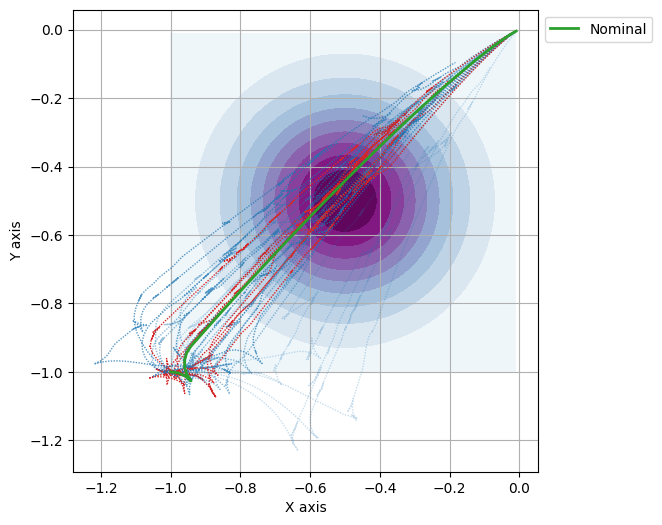

In [304]:
plot_trajectories_given_trajectory(concat_df, ref_df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


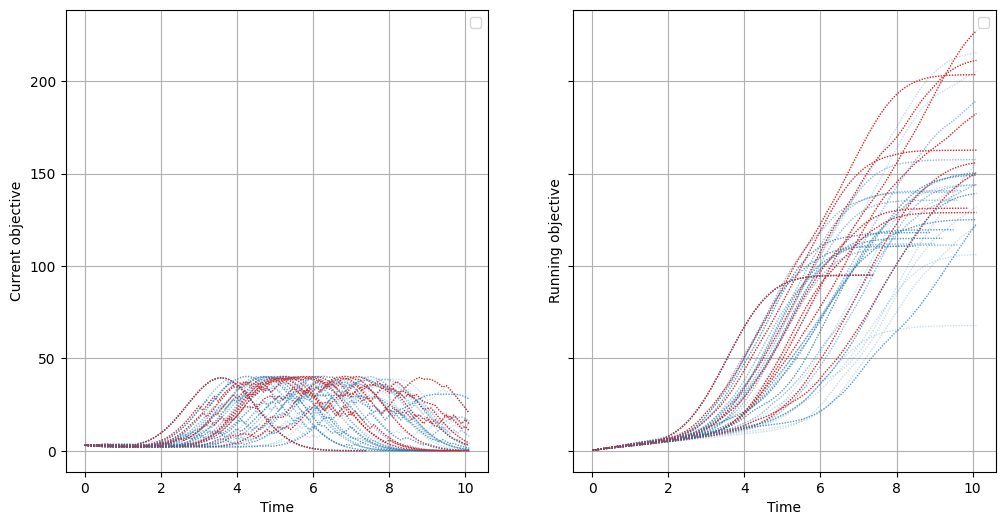

In [305]:
def plot_objective(df, ref_df=None):
    seeds = df["seed"].unique()

    fig, ax = plt.subplots(1,2,sharey=True, figsize=(12, 6))

    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        trials = list(sub_df_1["file_name"].unique())
        trials.sort()

        for param_trial in trials:
            sub_df_2 = sub_df_1[sub_df_1["file_name"] == param_trial]
            alpha = (sub_df_2["iteration_id"].max()/sub_df_1["iteration_id"].max())

            ax[0].plot(sub_df_2["time"], sub_df_2["current_value"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 1 else colors[50], 
                    alpha=alpha)
            
            ax[1].plot(sub_df_2["time"], sub_df_2["running_objective"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 1 else colors[50], 
                    alpha=alpha)
        
    if ref_df is not None:
        ax[0].plot(ref_df["time"], ref_df["current_value"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1)
        
        ax[1].plot(ref_df["time"], ref_df["running_objective"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1,
                label="nominal")

    # draw goal pose
    ax[0].legend(bbox_to_anchor=(1, 1))
    ax[1].legend(bbox_to_anchor=(1, 1))

    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Current objective')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Running objective')
    
    # Show the plot
    ax[0].grid(True)
    ax[1].grid(True)

    fig.savefig("media/objectives.svg", dpi=fig.dpi)


plot_objective(concat_df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


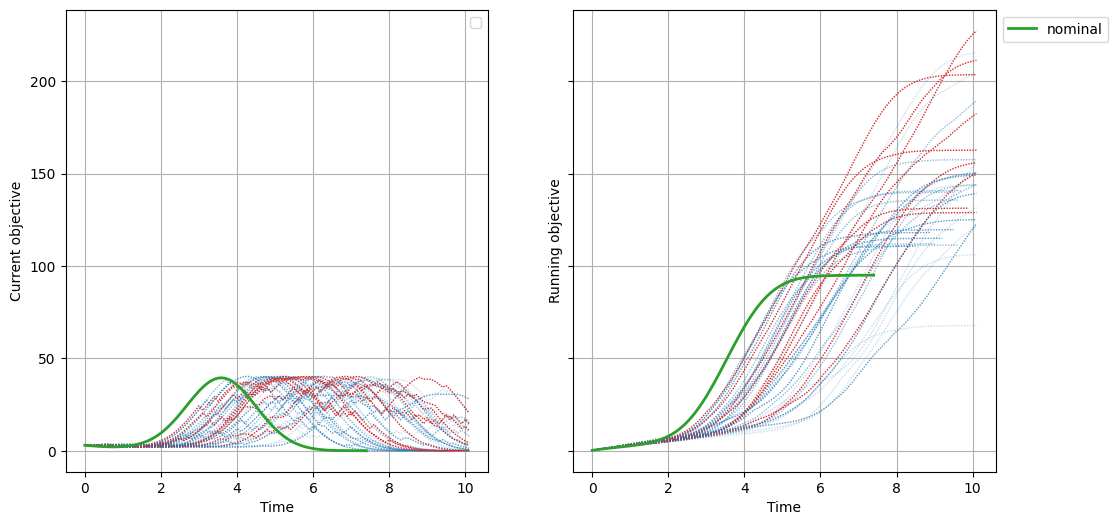

In [306]:
plot_objective(concat_df, ref_df)

/tmp/ipykernel_4079/3547287722.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_1["dis_2_goal"] = sub_df_1.apply(lambda row: np.linalg.norm([row["x [m]"], row["y [m]"]]), axis=1)
/tmp/ipykernel_4079/3547287722.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_1["dis_2_goal"] = sub_df_1.apply(lambda row: np.linalg.norm([row["x [m]"], row["y [m]"]]), axis=1)
/tmp/ipykernel_4079/3547287722.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],use_calf,critic_new,critic_safe,file_name,seed
0,0.0,0.306377,3.063771,1,1,-0.220000,-1.686472,-1.000000,-1.000000,3.141593,0,2594.734040,3586.839924,observations_actions_it_00001.h5,1
1,0.1,0.600609,2.942321,1,1,-0.156635,-1.714775,-0.978104,-1.001851,2.972945,0,2284.909531,2594.734040,observations_actions_it_00001.h5,1
2,0.2,0.884136,2.835270,1,1,-0.082791,-1.754036,-0.962963,-1.005788,2.801468,0,1695.514034,2284.909531,observations_actions_it_00001.h5,1
3,0.3,1.157879,2.737431,1,1,-0.045152,-1.524627,-0.955440,-1.009218,2.626064,0,1313.281943,1695.514034,observations_actions_it_00001.h5,1
4,0.4,1.423763,2.658836,1,1,-0.043003,-1.371859,-0.951696,-1.011734,2.473602,0,830.863166,1313.281943,observations_actions_it_00001.h5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,9.7,137.653054,6.381704,1,3,0.220000,-0.047562,-0.267581,-0.192790,0.689952,0,0.057009,0.055652,observations_actions_it_00003.h5,1
98,9.8,138.170797,5.177431,1,3,0.220000,-0.050724,-0.250580,-0.178827,0.685196,0,0.056408,0.055652,observations_actions_it_00003.h5,1
99,9.9,138.586138,4.153410,1,3,0.220000,-0.054359,-0.233510,-0.164948,0.680123,0,0.055721,0.055652,observations_actions_it_00003.h5,1
100,10.0,138.915653,3.295153,1,3,-0.220000,2.840000,-0.216368,-0.151159,0.674687,0,0.055651,0.055652,observations_actions_it_00003.h5,1


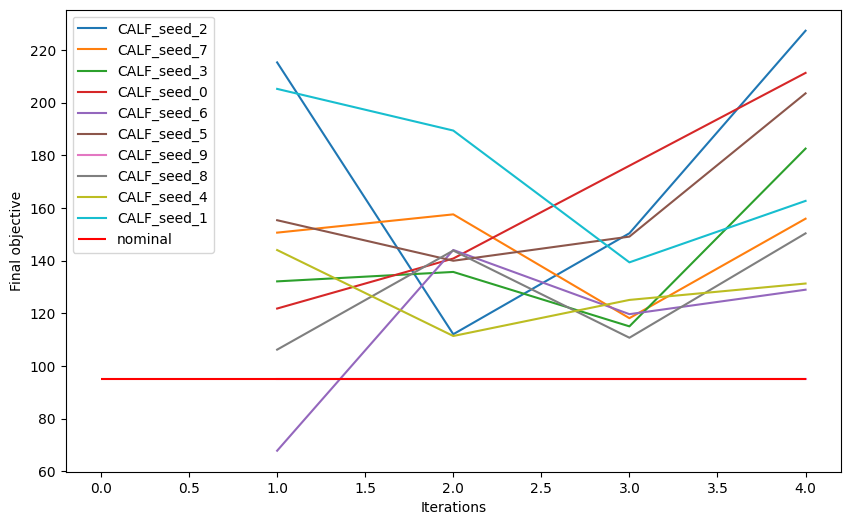

In [307]:
fig, ax = plt.subplots(figsize=(10, 6))

seeds = concat_df["seed"].unique()
for seed in seeds:
    sub_df_1 = concat_df[concat_df["seed"] == seed]
    sub_df_1["dis_2_goal"] = sub_df_1.apply(lambda row: np.linalg.norm([row["x [m]"], row["y [m]"]]), axis=1)
    sub_df_1 = sub_df_1[sub_df_1["dis_2_goal"] < 0.5]
    sub_df_1.groupby("iteration_id")["running_objective"].max().plot(ax=ax, label=f"CALF_seed_{seed}")

ax.hlines(ref_df["running_objective"].max(), 
        xmin=0, 
        xmax=concat_df["iteration_id"].max(), 
        colors="red",
        label="nominal")

ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Final objective')

sub_df_1 = concat_df[concat_df["seed"] == seed]
sub_df_1.apply(lambda row: np.linalg.norm([row["x [m]"], row["y [m]"]]), axis=1)
sub_df_1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


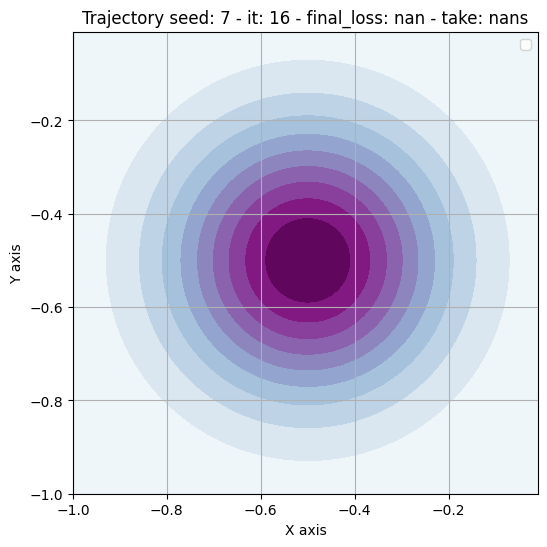

In [308]:
def plot_chosen_trajectory(df, it, seed=0, ref_df=None):
    fig, ax = plt.subplots(sharey=True, figsize=(6, 6))

    cs = ax.contourf(X, Y, Z, alpha=1, levels=10, cmap="BuPu")
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()

    sub_df_1 = df[df["seed"] == str(seed)]
    sub_df_2 = sub_df_1[sub_df_1["iteration_id"] == it]
    ax.plot(sub_df_2["x [m]"], sub_df_2["y [m]"], 
            linestyle=linestyle_dict[style[1]],
            lw=1, 
            color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 5 else colors[50], 
            alpha=1)

    ax.set_title("Trajectory seed: {} - it: {} - final_loss: {:.2f} - take: {:.2f}s".format(seed, it, sub_df_2["running_objective"].max(), sub_df_2["time"].max()))

    if ref_df is not None:
        ax.plot(ref_df["x [m]"], ref_df["y [m]"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1,
                label="Nominal")

    # draw goal pose
    ax.legend(bbox_to_anchor=(1, 1))

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    
    # Show the plot
    ax.grid(True)

    fig.savefig("media/trajectories.svg", dpi=fig.dpi)

plot_chosen_trajectory(concat_df, it=16, seed=7)